Leonie Färber  
09.01.2024

# Physical Activity and Health in Europe

## Introduction  
In recent years, there has been a significant increase in the number of people living a sedentary lifestyle in Europe. This lifestyle change may have negative impacts on people's health. This project aims to study the relationship between the average amount of time spent on physical activity and the health of the population in European countries. Two indicators will be used to evaluate health levels. Firstly, the percentage of people reporting depressive symptoms will be considered as an indicator of mental health. Secondly, self-reported perceived health will be used to assess general health.

## Methods  
### Datasources  
### Datasource1: Time spent on physical activity
* Title: Time spent on health-enhancing (non-work-related) aerobic physical activity by sex, age and educational attainment level
* Metadata URL: https://ec.europa.eu/eurostat/databrowser/view/hlth_ehis_pe2e$dv_300/default/table?lang=de
* Data URL: https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/HLTH_EHIS_PE2E/?format=SDMX-CSV&lang=en&label=label_only
* Data Type: CSV
* Source of Data: [Eurostat](https://ec.europa.eu/eurostat/databrowser/view/hlth_ehis_pe2e$dv_300/default/table)
* License: [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)

Time spent on health-promoting (non-work-related) physical activity by country and year.

### Datasource2: Depressive symptoms
* Title: Current depressive symptoms by sex, age and educational attainment level
* Metadata URL: https://ec.europa.eu/eurostat/databrowser/view/hlth_ehis_mh1e/default/table?lang=de
* Data URL: https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/hlth_ehis_mh1e/?format=SDMX-CSV&lang=en&label=label_only
* Data Type: CSV
* Source of Data: [Eurostat](https://ec.europa.eu/eurostat/databrowser/view/hlth_ehis_mh1e/default/table)
* License: [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)

Current depressive symptoms by country and year.

### Datasource3: Self-report on general health
* Title: Self-perceived health by sex, age and educational attainment level
* Metadata URL: https://ec.europa.eu/eurostat/databrowser/view/hlth_silc_02/default/table?lang=de
* Data URL: https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/hlth_silc_02/?format=SDMX-CSV&lang=en&label=label_only
* Data Type: CSV
* Source of Data: [Eurostat](https://ec.europa.eu/eurostat/databrowser/view/hlth_silc_02/default/table)
* License: [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)

Self-report on health by country and year

### Selection of Data Sources
The choice of data sources was mainly influenced by the quality of the provided data. Finding comparable data sources on health and movement that offer a similar volume of data for all included countries on a worldwide scale proved challenging. Additionally, comparing the effect of movement on health loses significance drastically if inhabitants of the compared countries have vastly different lifestyles. While choosing a more global scale for this project might be generally interesting, it would require checking for multiple other correlating factors to produce meaningful findings. This would go beyond the intended scope of this project. Therefore, this project limits its scope to a much smaller area. Europe provides comparable living standards and is of particular interest since inhabitants are, on average, becoming more sedentary due to factors such as the effects of digitalization. The chosen data sources allow us to make reasonable comparisons since the measurements were taken in the same time frame and from the same set of countries.

### Data Pipeline
#### Extract
In the first step, the data is extracted from the provided source files. The data pipeline uses the pandas library to read the data from the CSV files and convert it into a pandas DataFrame.

#### Transform
Some transformation steps have to be made for all datasets:
- Drop any rows that have null values in the country or value (percentage of the population) columns: These pieces of information are crucial for drawing comparisons between datasets.
- Standardize values: For some columns, only a singular value is of interest to this project. We selected most of these values with the intention of increasing comparability or decreasing the number of data points to evaluate. This step ensures that the data fits into a reasonable scope. The set values include an 'annual' frequency, 'percentage' as the unit, 'total' values for sex and education (ISCED11), and '2014' as well as '2019' for the time period. We limit the time period to these two years since only one dataset includes data points from more years.
- Drop generalized rows: Rows that provide values for all of Europe combined are too generalized to gain the insights we want. They do not allow for inter-country comparisons and are thus dropped.
- Check for null values in the observation flag: If the observation flag is non-null, the data is marked as uncertain due to sample size and other issues.
- Drop any columns that we just set a specific value for as well as any columns containing metadata (such as DATAFLOW and last_update).
- Rename columns for readability.

Other transformations are specific to each dataset:  
  
**Physical activity data**
- Drop any rows that have null values in the duration column: The duration column provides us with information on activity levels and is thus crucial.
- Set the age to total (here 18 and above): This is similar for all datasets, but the age of study participants varies.
- Exclude overlapping values from the duration: Some duration labels are included in others and must be removed before calculating an average duration.
- Convert string labels for durations to numbers: The durations are given in intervals and named as strings. To be able to calculate an average duration, they must be numerical. For this, we select the mean as a representative value for each interval. This process decreases the accuracy of the data but is necessary for comparisons. This limitation is further addressed in the discussion section of this report.

**Mental Health Data**
- Drop rows with null values in the health problems column (similar as above)
- Select total age (here 18 and above)
- Exclude the 'depressive symptoms' value which combines both major as well as other depressive symptoms: Again, this value is too generalized for our usage. We plan on differentiating different depressive symptoms.
- Transform labels to numbers: Set 'no symptoms' to 0 since these values are not recorded in the dataset. This allows us to make graphic comparisons later on.

**General Health Data**
- Drop rows with null values in the health levels column.
- Select total age (here 16 and above): The age intervals do not allow for taking out data between the ages of 16 and 17. This is another limitation set by the data since it is not entirely comparable to the other two datasets.
- Drop rows that include summarized health levels to get rid of overlapping data.
- Map health level labels to a numerical scale from -2 to 2: This again allows for averaging values, better comparisons, and visualization.

#### Load
After the data has been transformed, the last step is to load the results to their destination sqlite file. In this step the different data sources were not merged into one table to increase flexibility for the interpretation and joining of the data.


## Results
### Preparation
#### Dependencies

In [1]:
%pip install pandas
%pip install 'SQLAlchemy==1.4.46'
%pip install matplotlib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


#### Imports

In [2]:
import os
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns

#### Load Data

In [3]:
# if data file does not exist, run pipeline
if not os.path.exists("../data/result.sqlite"):
    subprocess.run(["python", "pipeline.py"])

# connect to SQLite database
conn = sqlite3.connect('../data/result.sqlite')

# SQL queries
query_activity = '''
    SELECT country, year, SUM(duration_in_min * (percentage_of_population / 100)) AS activity
    FROM activity
    GROUP BY country, year
'''
query_general_health = '''
    SELECT country, year, SUM(general_health * (percentage_of_population / 100)) AS general_health
    FROM general_health
    GROUP BY country, year
'''
query_mental_health = '''
    SELECT country, year, SUM(depressive_symptoms * (percentage_of_population / 100)) AS depressive_symptoms
    FROM mental_health
    GROUP BY country, year
'''

# read DataFrames from the database
df_activity = pd.read_sql_query(query_activity, conn)
df_general_health = pd.read_sql_query(query_general_health, conn)
df_mental_health = pd.read_sql_query(query_mental_health, conn)

# close the database connection
conn.close()

# merge or concatenate the DataFrames
common_identifiers = ['country', 'year']
merged_df = pd.merge(df_activity, df_general_health, on=common_identifiers)
merged_df = pd.merge(merged_df, df_mental_health, on=common_identifiers)



### Analysis

#### Data Presentation
First, we will present each data category individually using box plots.
  
**General Health**  
The self report on general health was measured on a scale from -2 to 2 with the following use of labels:  
> -2: Very bad  
> -1: Bad  
> 0: Fair  
> 1: Good  
> 2: Very good  

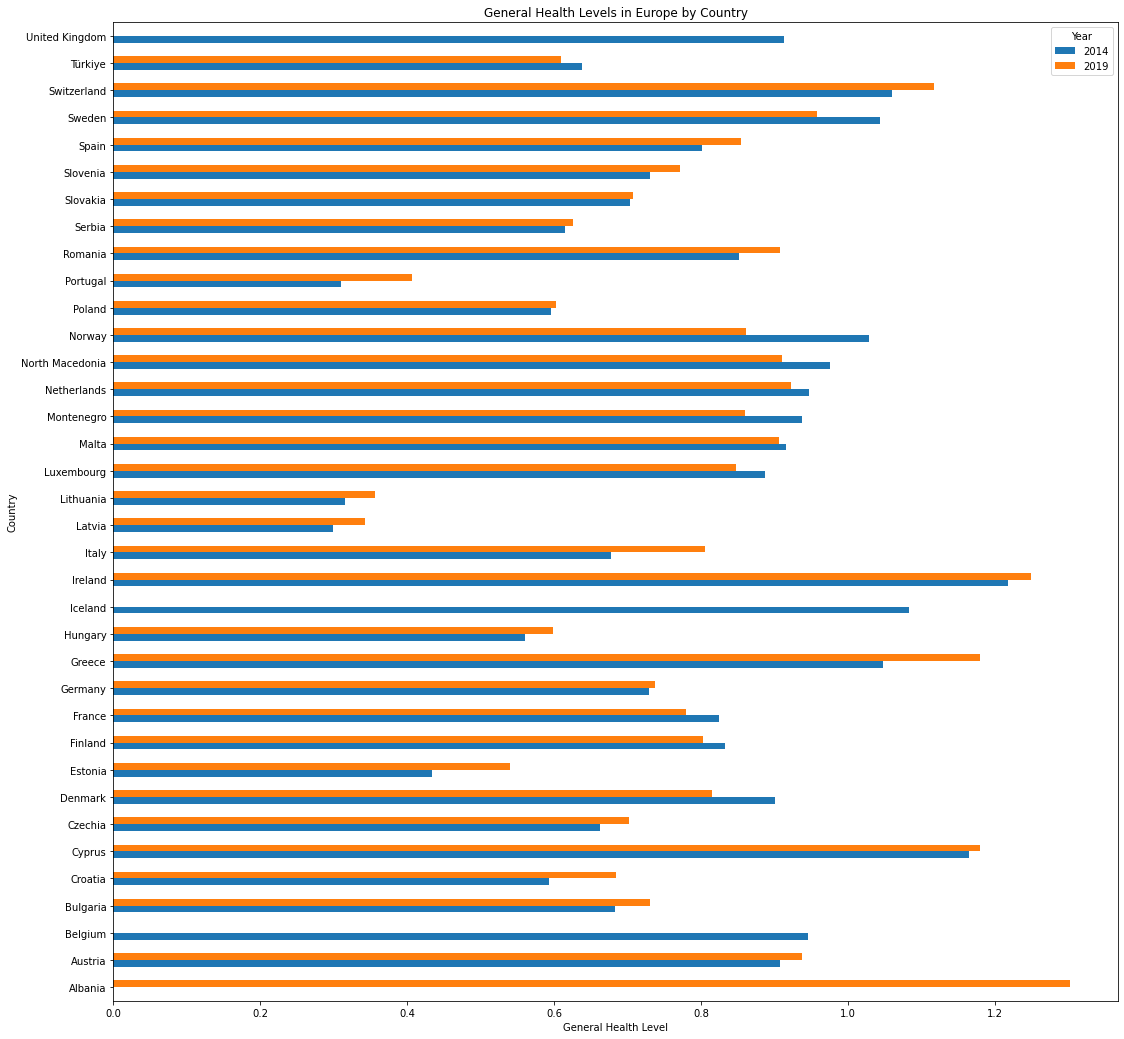

In [11]:
# pivoting the data to have years as columns and countries on the index
pivot_data = df_general_health.pivot(index='country', columns='year', values='general_health')

# plotting bar diagram
pivot_data.plot(kind='barh', rot=0, figsize=(22, 18))
plt.title('General Health Levels in Europe by Country')
plt.xlabel('General Health Level')
plt.ylabel('Country')
plt.legend(title='Year')
plt.show()



**Mental Health**  
The indicator of mental health in this project is the average severity of depressive symptoms. The severity of depressive symptoms is measured using the following scale:
> 0: No depressive symptoms  
> 1: Other depressive symptoms  
> 2: Major depressive symptoms  

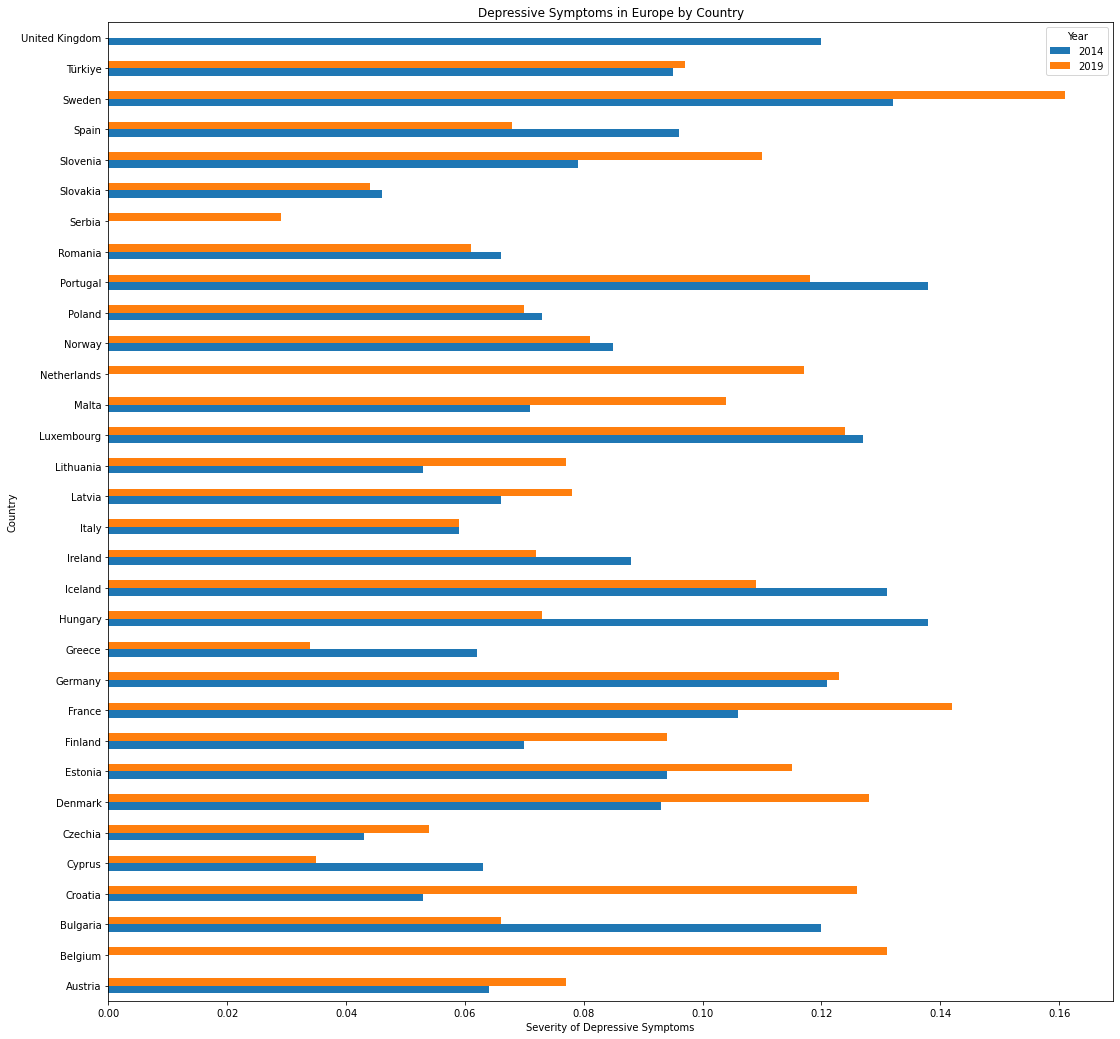

In [12]:

# pivoting the data to have years as columns and countries on the index
pivot_data = df_mental_health.pivot(index='country', columns='year', values='depressive_symptoms')

# plotting the bar diagram
pivot_data.plot(kind='barh', rot=0, figsize=(22, 18))
plt.title('Depressive Symptoms in Europe by Country')
plt.xlabel('Severity of Depressive Symptoms')
plt.ylabel('Country')
plt.legend(title='Year')
plt.show()

**Physical Activity**  
The physical activity was measured in minutes per week.

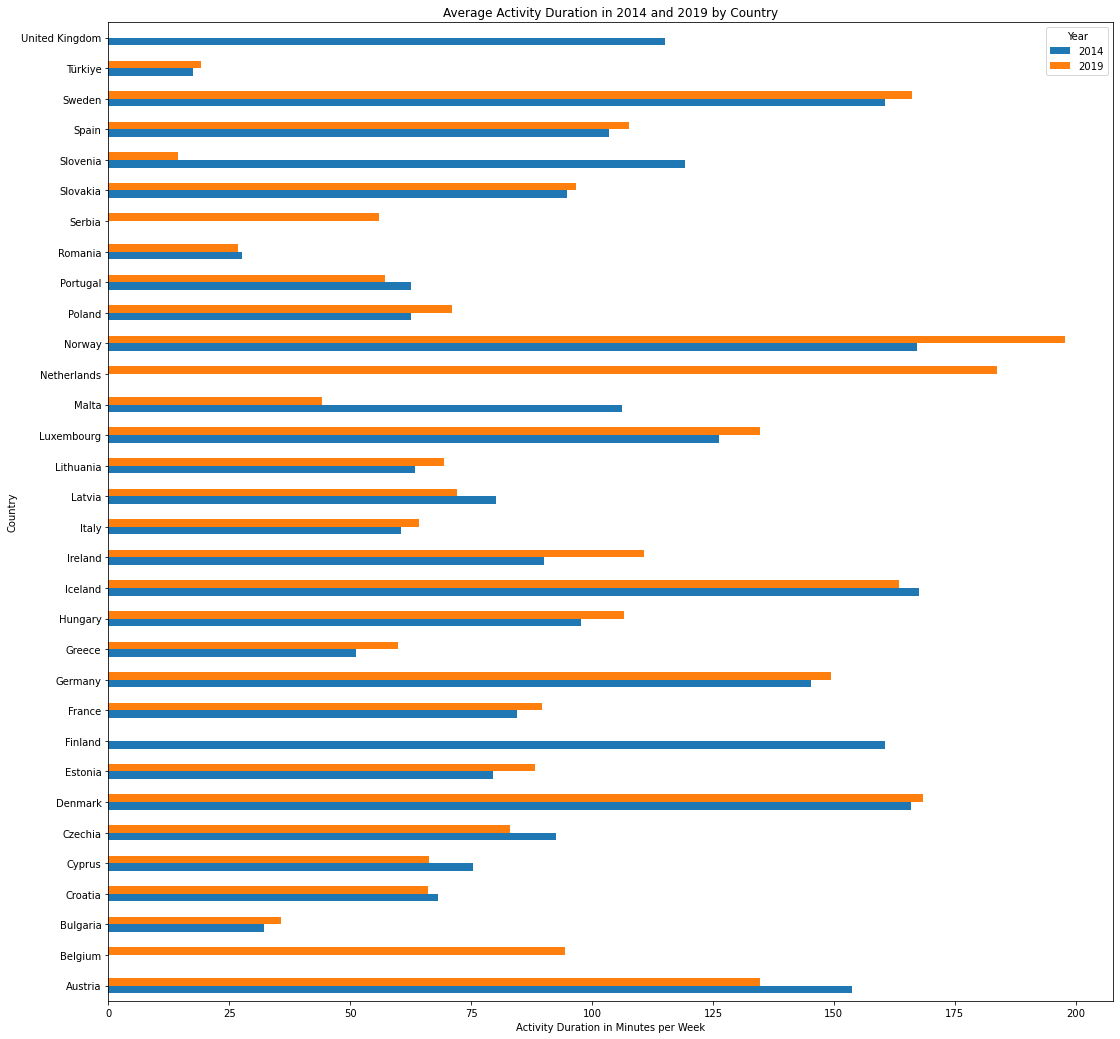

In [13]:
# pivoting the data to have years as columns and countries on the index
pivot_data = df_activity.pivot(index='country', columns='year', values='activity')

# plotting the bar diagram
pivot_data.plot(kind='barh', rot=0, figsize=(22, 18))
plt.title('Average Activity Duration in 2014 and 2019 by Country')
plt.xlabel('Activity Duration in Minutes per Week')
plt.ylabel('Country')
plt.legend(title='Year')
plt.show()

#### Data Distribution
To display the data distribution we use violin plots.

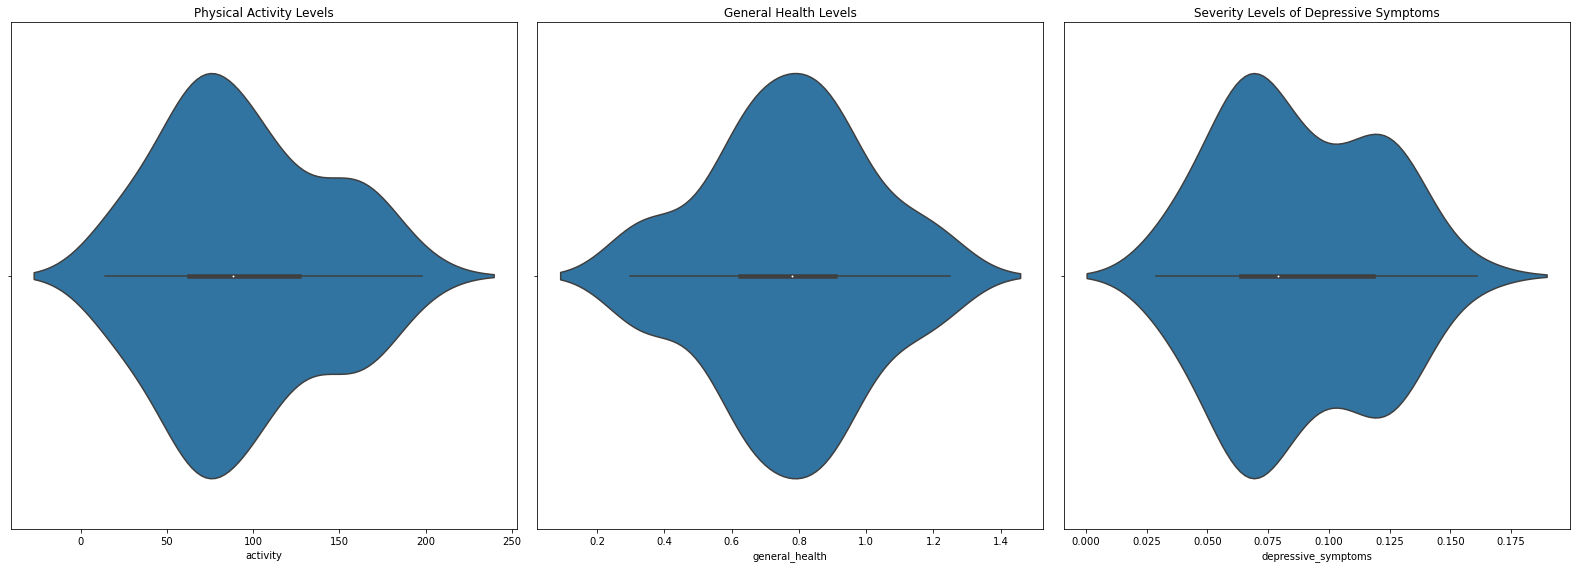

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(22, 8))

sns.violinplot(x='activity', data=merged_df, ax=axes[0])
axes[0].set_title('Physical Activity Levels')

sns.violinplot(x='general_health', data=merged_df, ax=axes[1])
axes[1].set_title('General Health Levels')

sns.violinplot(x='depressive_symptoms', data=merged_df, ax=axes[2])
axes[2].set_title('Severity Levels of Depressive Symptoms')

plt.tight_layout()
plt.show()

#### Data Correlation
To evaluate possible correlations we draw scatter plots of all variable combinations. To increase the legibility of the diagrams the data poins were not named. For an overview on specific countries please refer to the data presentation section of this report.

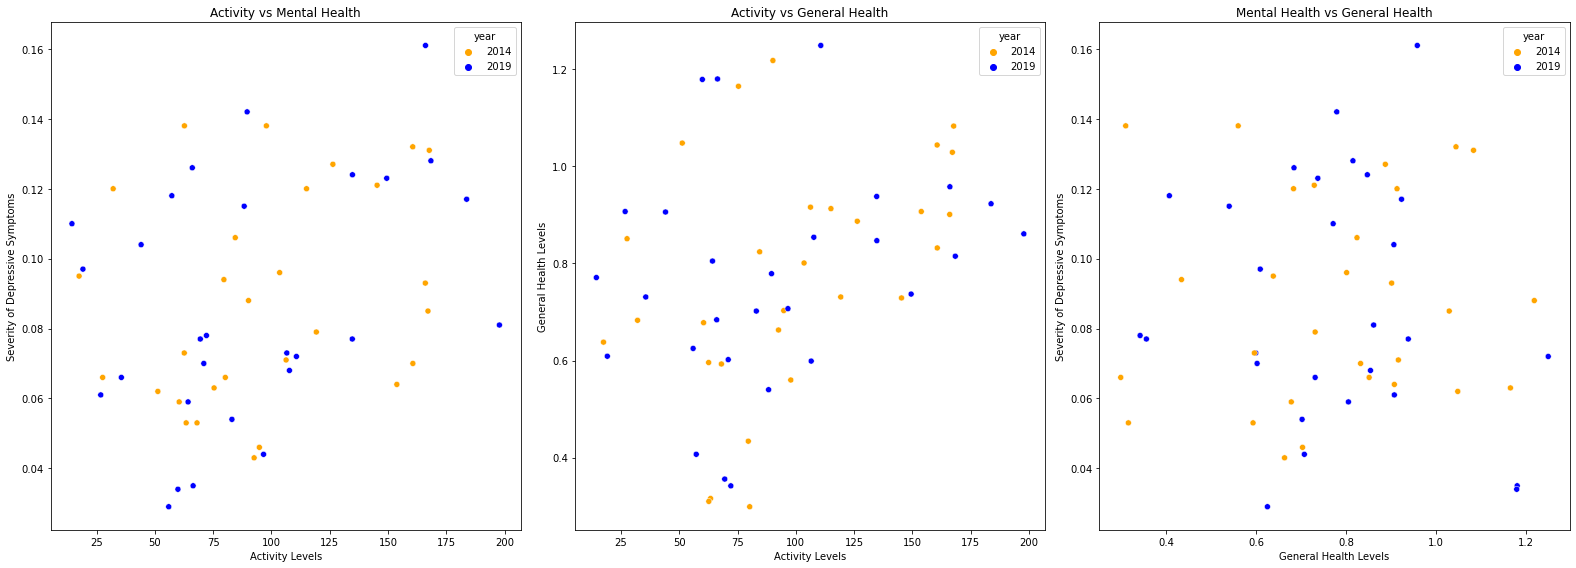

In [22]:
# create subplots
fig, axes = plt.subplots(1, 3, figsize=(22, 8))

# scatter plot activit x mental
sns.scatterplot(x='activity', y='depressive_symptoms', hue='year', palette={2014: 'orange', 2019: 'blue'}, data=merged_df, ax=axes[0])
axes[0].set_title('Activity vs Mental Health')
axes[0].set_xlabel('Activity Levels')
axes[0].set_ylabel('Severity of Depressive Symptoms')

# scatter plot activity x general
sns.scatterplot(x='activity', y='general_health', hue='year', palette={2014: 'orange', 2019: 'blue'}, data=merged_df, ax=axes[1])
axes[1].set_title('Activity vs General Health')
axes[1].set_xlabel('Activity Levels')
axes[1].set_ylabel('General Health Levels')

# scatter plot mental x general
sns.scatterplot(x='general_health', y='depressive_symptoms', hue='year', palette={2014: 'orange', 2019: 'blue'}, data=merged_df, ax=axes[2])
axes[2].set_title('Mental Health vs General Health')
axes[2].set_xlabel('General Health Levels')
axes[2].set_ylabel('Severity of Depressive Symptoms')

plt.tight_layout()
plt.show()


The correlation coeficients can be displayed in a heat map:

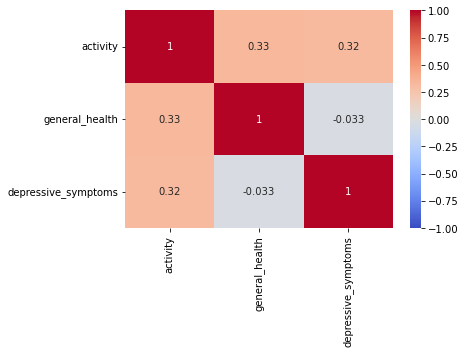

In [9]:
correlation_matrix = merged_df[['activity', 'general_health', 'depressive_symptoms']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

## Discussion

The raw data shows a very slight upward trend from 2014 to 2019 in countries with increasing general health and a very slight downward trend for mental health. For physical activity, there is also a slight majority of countries experiencing an increase in activity. However since we can only draw comparisons between two years, these trends are too small to be significant. In addition, there are countries with only one measurement which makes any noticeable trends even more insignificant. It would be interesting to look at a larger-scale dataset to allow for more insight into pan-European developments over time.  
The distribution of data points shows that the variance in general health data is somewhat low. The data points range between 0 and 1.5 even though the scale goes from -2 to 2. This was to be expected since we specifically chose Europe for its relatively similar standard of living between countries. On the one hand, this allows us to calculate more exact correlation coefficients since some other correlating factors can be excluded from further consideration. On the other hand, this somewhat limits the correlations we can see since the range of data points does not cover the full general health scale. For any further evaluations, we have to consider that any correlation that we may find can only be applicable in the range of fair to (very) good health. The data points for activity levels and mental health are more evenly distributed throughout the range of their scale.
When looking at the scatter plots we can see some slight trends for correlation between activity and health. To better evaluate this we displayed the correlation coefficients in a heat map. A correlation coefficient of 0.32 and 0.33 in the context of psychology and health would generally be considered a weak to moderate positive correlation. This suggests that there is a discernible relationship between the two variables, but the association is not extremely strong. For the correlation between activity and general health, a coefficient of 0.33 might indicate that individuals who engage in higher levels of physical activity tend to have moderately better general health scores. However, the relationship is not strong enough to make precise predictions about one variable based on the other. This outcome somewhat fits our expectations and other research in this field. Even though we would have wished for a more concise outcome.  
The correlation between mental health and activity seems similar to the above correlation. However, it has to be interpreted differently. Here we have a 0.32 correlation coefficient. Which means a weak to moderate correlation between physical activity and the severity of depressive symptoms. So according to these findings one tends to have moderately more severe depressive symptoms if one engages in higher levels of physical activity.Therefore, this is not an outcome we would expect or that other research on this topic would suggest.  
Another interesting point is that the correlation coefficient suggests that there is no correlation between general health and mental health. This is also a somewhat unexpected outcome.  
In conclusion, what can we learn from these findings? Mostly how difficult answering the question of correlation and causality is in the field of psychology and health. However, it is interesting to evaluate why our outcomes partially differ from recent research. 
To obtain better results we must consider many more correlating factors. These may include gender, age, education and more. Also, we must look at the premise of our survey. The general health was evaluated using self-report on a relatively vague scale. Also, it was the only data set gathering data from the age of 16 not 18. The measurements for activity duration were averaged twice. Once concerning the labels and once concerning each country. This makes the data points less reliable. Furthermore, mental health is not only comprised of depression. Including other mental health diseases and factors would allow for a more precise discussion about mental health and physical activity. Additionally, there are multiple other factors that could be considered in future work. Increasing sample sizes, decreasing the interval between measurements, and collecting data on a personal level rather than per country would provide more precise outcomes.  
Generally speaking, many more insights can be gathered in the still relatively young field of health psychology. And while finding plausible correlations might prove difficult in some areas as shown above, modern society could benefit immensely from understanding the links between health and lifestyle.